In [7]:
from pymongo import MongoClient
import polars as pl

In [8]:
# Conectar ao MongoDB
client = MongoClient("mongodb://localhost:27017")  # Conectar ao MongoDB local
db = client["ctt2025"]  # Nome da base de dados no MongoDB
collection = db["expresso_2025"]  # Nome da coleção (tabela)

In [9]:


# Consulta de agregação
pipeline = [
    # Filtro para garantir que estamos lidando com dados válidos
    {"$match": {"DATA_CRIACAO": {"$exists": True}, "CENTRO": {"$exists": True}}},
    
    # Agrupar por DATA_CRIACAO e CENTRO, contar os documentos
    {"$group": {
        "_id": {"DATA_CRIACAO": "$DATA_CRIACAO", "CENTRO": "$CENTRO"},  # Agrupar por DATA e CENTRO
        "numero_de_objetos": {"$sum": 1}  # Contar o número de documentos em cada grupo
    }},
    
    # Ordenar pela DATA_CRIACAO
    {"$sort": {"_id.DATA_CRIACAO": 1}}  # Ordenar pela data
]

# Executar a agregação
resultado = collection.aggregate(pipeline)

# Coletar os resultados e transformar em uma lista de dicionários
dados = []
for item in resultado:
    dados.append({
        "centro": item["_id"]["CENTRO"],
        "data": item["_id"]["DATA_CRIACAO"],
        "numero_de_objetos": item["numero_de_objetos"]
    })

# Definir um schema explícito para o DataFrame
schema = [
    ("centro", pl.Utf8),
    ("data", pl.Utf8),
    ("numero_de_objetos", pl.Int64)
]

# Criar um DataFrame Polars com os dados e schema
df = pl.DataFrame(dados, schema=schema)

# Mostrar o DataFrame
print(df)


shape: (4_034, 3)
┌─────────┬────────────┬───────────────────┐
│ centro  ┆ data       ┆ numero_de_objetos │
│ ---     ┆ ---        ┆ ---               │
│ str     ┆ str        ┆ i64               │
╞═════════╪════════════╪═══════════════════╡
│ 8811457 ┆ 01/07/2025 ┆ 2490              │
│ 8811456 ┆ 01/07/2025 ┆ 8908              │
│ 8817018 ┆ 01/07/2025 ┆ 18483             │
│ 8819001 ┆ 01/07/2025 ┆ 10977             │
│ 8819009 ┆ 01/07/2025 ┆ 21189             │
│ …       ┆ …          ┆ …                 │
│ 419006  ┆ ROWCOUNT   ┆ 1                 │
│ 426003  ┆ ROWCOUNT   ┆ 1                 │
│ 444295  ┆ ROWCOUNT   ┆ 1                 │
│ 74596   ┆ ROWCOUNT   ┆ 1                 │
│ 494095  ┆ ROWCOUNT   ┆ 1                 │
└─────────┴────────────┴───────────────────┘


In [ ]:
# Recuperar todos os dados da coleção
dados = []
for item in collection.find():
    dados.append({
        "centro": item.get("CENTRO"),
        "data": item.get("DATA_CRIACAO"),
        "giro": item.get("Giro"),
        "loptica": item.get("LOPTICA"),
        "janela_horaria": item.get("JANELA_HORARIA"),
        "nome": item.get("NOME"),
        "morada": item.get("MORADA"),
        "cp": item.get("CP"),
        "localidade": item.get("LOCALIDADE"),
        "cod_t_even": item.get("COD_T_EVEN"),
        "data_evento": item.get("DATA_EVENTO"),
        "latitude": item.get("LATITUDE"),
        "longitude": item.get("LONGITUDE"),
        "nome_rem": item.get("NOME_REM"),
        "cod_pais_origem": item.get("COD_PAIS_ORIGEM")
    })

# Criar o DataFrame Polars com os dados
df = pl.DataFrame(dados)


In [ ]:
df.head()

shape: (0, 0)
┌┐
╞╡
└┘

In [ ]:
df_agregado = df.group_by(["centro", "data"]).agg([
    pl.count().alias("numero_de_objetos")
])

# Mostrar o DataFrame agregado
df_agregado.head()

C:\Users\1420844\AppData\Local\Temp\ipykernel_14020\2801477233.py:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("numero_de_objetos")


ColumnNotFoundError: unable to find column "centro"; valid columns: []

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF []; PROJECT */0 COLUMNS

In [ ]:
import polars as pl
from datetime import datetime

# Dicionários
meses_portugues = {
    'January': 'Janeiro', 'February': 'Fevereiro', 'March': 'Março', 'April': 'Abril',
    'May': 'Maio', 'June': 'Junho', 'July': 'Julho', 'August': 'Agosto',
    'September': 'Setembro', 'October': 'Outubro', 'November': 'Novembro', 'December': 'Dezembro'
}
meses_numeros = {
    'Janeiro': 1, 'Fevereiro': 2, 'Março': 3, 'Abril': 4,
    'Maio': 5, 'Junho': 6, 'Julho': 7, 'Agosto': 8,
    'Setembro': 9, 'Outubro': 10, 'Novembro': 11, 'Dezembro': 12
}

# Função para converter datas mistas
def parse_date_mista(date_str: str):
    formatos = ['%Y-%m-%d', '%Y.%m.%d', '%d/%m/%Y', '%Y/%m/%d']
    for fmt in formatos:
        try:
            return datetime.strptime(date_str, fmt)
        except:
            continue
    return None

# Exemplo: carregar CSV
# df = pl.read_csv("teu_arquivo.csv")

# Aplicar a função Python com map_elements
df = df.with_columns([
    pl.col("data").map_elements(parse_date_mista, return_dtype=pl.Datetime).alias("data_parsed")
])

# Criar semana e mês em português
df = df.with_columns([
    pl.col("data_parsed").dt.week().alias("semana_ano"),
    pl.col("data_parsed").dt.strftime("%B")
        .map_elements(lambda m: meses_portugues.get(m, m), return_dtype=pl.Utf8).alias("mes"),
    pl.col("cp").str.len_chars().alias("cp_length")
])

# Agrupamento e cálculo
percentagem_por_semana = (
    df.group_by(["semana_ano", "mes"])
      .agg([
          (pl.col("cp_length") == 8).sum().alias("n_cp_8"),
          pl.count().alias("total")
      ])
      .with_columns([
          ((pl.col("n_cp_8") / pl.col("total")) * 100).round(1).alias("percentagem_cp_comprimento_8"),
          (pl.col("semana_ano").cast(pl.Utf8) + "-" + pl.col("mes")).alias("semana_mes"),
          pl.col("mes").map_elements(lambda m: meses_numeros.get(m, 0), return_dtype=pl.Int8).alias("mes_num")
      ])
      .sort(["mes_num", "semana_ano"])
)

# Mostrar resultado
print(percentagem_por_semana.select(["semana_mes", "percentagem_cp_comprimento_8"]))


C:\Users\1420844\AppData\Local\Temp\ipykernel_320\1715198759.py:47: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("total")


shape: (9, 2)
┌────────────┬──────────────────────────────┐
│ semana_mes ┆ percentagem_cp_comprimento_8 │
│ ---        ┆ ---                          │
│ str        ┆ f64                          │
╞════════════╪══════════════════════════════╡
│ 13-Março   ┆ 97.8                         │
│ 14-Março   ┆ 97.4                         │
│ 14-Abril   ┆ 97.5                         │
│ 15-Abril   ┆ 97.6                         │
│ 16-Abril   ┆ 97.5                         │
│ 17-Abril   ┆ 97.8                         │
│ 18-Abril   ┆ 97.6                         │
│ 18-Maio    ┆ 97.7                         │
│ 19-Maio    ┆ 97.5                         │
└────────────┴──────────────────────────────┘


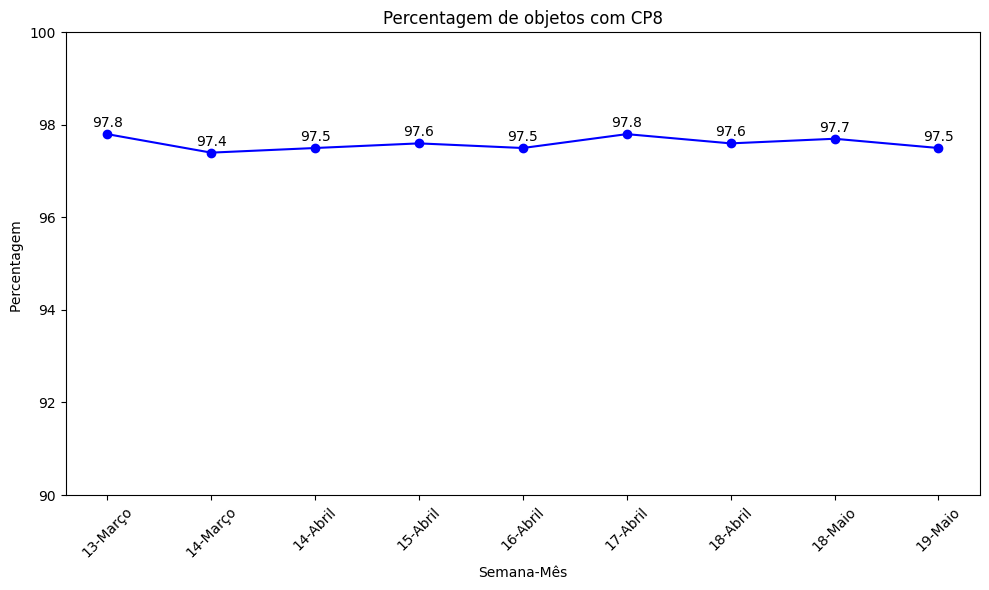

In [ ]:
import matplotlib.pyplot as plt

# Adicionar (ou reatribuir) as colunas de ordenação
percentagem_por_semana = percentagem_por_semana.with_columns([
    pl.col("semana_mes").map_elements(lambda x: meses_numeros[x.split('-')[1]], return_dtype=pl.Int8).alias("mes_num"),
    pl.col("semana_mes").map_elements(lambda x: int(x.split('-')[0]), return_dtype=pl.Int8).alias("semana_ano")
])

# Função para criar gráfico com labels
def criar_grafico_com_labels(resultado_pl, y_min=None, y_max=None):
    # Ordenar e converter para pandas
    resultado = resultado_pl.sort(["mes_num", "semana_ano"]).to_pandas()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(resultado['semana_mes'], resultado['percentagem_cp_comprimento_8'], marker='o', linestyle='-', color='blue')
    ax.set_xlabel('Semana-Mês')
    ax.set_ylabel('Percentagem ')
    ax.set_title('Percentagem de objetos com CP8')

    # Adicionar labels
    for i, txt in enumerate(resultado['percentagem_cp_comprimento_8']):
        ax.annotate(f'{txt}', (resultado['semana_mes'].iloc[i], resultado['percentagem_cp_comprimento_8'].iloc[i]),
                    textcoords="offset points", xytext=(0, 5), ha='center')

    if y_min is not None and y_max is not None:
        ax.set_ylim(y_min, y_max)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Usar a função
criar_grafico_com_labels(percentagem_por_semana, y_min=90, y_max=100)

# Alta qualidade em notebooks (ignorado fora deles)
try:
    get_ipython().run_line_magic('config', 'InlineBackend.figure_format = "svg"')
except:
    pass


In [ ]:
from pymongo import MongoClient
import re
from collections import defaultdict

# Conexão à base de dados
def conecta_db():
    client = MongoClient('mongodb://localhost:27017/')
    return client['ctt2025']

# Obter e analisar formatos de data
def listar_formatos_data():
    db = conecta_db()
    colecao = db['recolhas_2025']
    
    # Obter valores distintos do campo "data"
    datas = colecao.distinct("DATA_FICHEIRO")
    
    formatos_encontrados = defaultdict(list)

    # Expressões regulares comuns
    regex_formatos = {
        "DD/MM/YYYY": re.compile(r"^\d{2}/\d{2}/\d{4}$"),
        "YYYY-MM-DD": re.compile(r"^\d{4}-\d{2}-\d{2}$"),
        "YYYY.MM.DD": re.compile(r"^\d{4}\.\d{2}\.\d{2}$"),
        "DD-MM-YYYY": re.compile(r"^\d{2}-\d{2}-\d{4}$"),
        "timestamp": re.compile(r"^\d{10}$"),
        "datetime ISO": re.compile(r"^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}"),
        "outro": re.compile(r".*")
    }

    # Classificar cada data segundo o seu formato
    for data in datas:
        if not isinstance(data, str):
            formatos_encontrados["não é string"].append(data)
            continue

        data = data.strip()
        encontrado = False
        for nome_formato, regex in regex_formatos.items():
            if regex.match(data):
                formatos_encontrados[nome_formato].append(data)
                encontrado = True
                break
        if not encontrado:
            formatos_encontrados["formato desconhecido"].append(data)

    # Mostrar todos os resultados
    for formato, exemplos in formatos_encontrados.items():
        print(f"\nFormato: {formato} — {len(exemplos)} ocorrência(s)")
        for ex in exemplos:
            print("  ", ex)

listar_formatos_data()


In [ ]:

from pymongo import MongoClient

# Conexão à base de dados
def conecta_db():
    client = MongoClient('mongodb://localhost:27017/')
    return client['ctt2025']

# Remover o campo 'DATA' de todos os documentos onde ele existe
def remover_campo_DATA():
    db = conecta_db()
    colecao = db['rede_base_2025']
    
    resultado = colecao.update_many(
        { "DATA_CRIACAO": { "$exists": True } },  # apenas documentos que têm o campo DATA (maiúsculas)
        { "$unset": { "DATA_CRIACAO": "" } }      # remove o campo
    )
    
    print(f"Documentos atualizados: {resultado.modified_count}")

remover_campo_DATA()


Documentos atualizados: 1611621


In [ ]:
from pymongo import MongoClient

# Conexão à base de dados
def conecta_db():
    client = MongoClient('mongodb://localhost:27017/')
    return client['ctt2025']

# Eliminar documentos com data_criacao = "2025.06.30"
def eliminar_docs_com_data():
    db = conecta_db()
    colecao = db['expresso_2025']

    resultado = colecao.delete_many({ "data_criacao": "2025.06.30" })

    print(f"Documentos eliminados: {resultado.deleted_count}")

eliminar_docs_com_data()


Documentos eliminados: 162014


In [ ]:
from pymongo import MongoClient
import hashlib
import json
from collections import defaultdict
import pprint

# Definições iniciais
bd = "ctt2025"
tabela = "expresso_2025"

def conecta_client():
    return MongoClient('mongodb://localhost:27017/')

# Gera hash rigoroso com campos e conteúdos exatamente iguais (exceto _id)
def hash_documento_rigoroso(doc):
    doc_sem_id = {k: doc[k] for k in sorted(doc) if k != "_id"}
    try:
        serializado = json.dumps(doc_sem_id, sort_keys=True, ensure_ascii=False)
        hash_val = hashlib.md5(serializado.encode("utf-8")).hexdigest()
        return hash_val, doc_sem_id
    except Exception as e:
        print(f"Erro ao serializar documento: {e}")
        return None, None

# Verifica duplicados numa base e coleção específicas
def verificar_duplicados_rigorosos(bd, tabela):
    client = conecta_client()
    pp = pprint.PrettyPrinter(indent=2)

    if bd not in client.list_database_names():
        print(f"❌ Base de dados '{bd}' não existe.")
        return

    db = client[bd]

    if tabela not in db.list_collection_names():
        print(f"❌ Coleção '{tabela}' não existe em '{bd}'.")
        return

    colecao = db[tabela]
    print(f"\n🔍 A verificar duplicados em: {bd}.{tabela}")

    hash_to_ids = defaultdict(list)
    hash_to_exemplo = {}

    cursor = colecao.find({}, no_cursor_timeout=True).batch_size(1000)

    try:
        for doc in cursor:
            h, doc_sem_id = hash_documento_rigoroso(doc)
            if h:
                hash_to_ids[h].append(doc["_id"])
                if h not in hash_to_exemplo:
                    hash_to_exemplo[h] = doc_sem_id
    except Exception as e:
        print(f"Erro ao processar documentos: {e}")
    finally:
        cursor.close()

    duplicados = {h: ids for h, ids in hash_to_ids.items() if len(ids) > 1}

    if duplicados:
        print(f"⚠️  {len(duplicados)} grupo(s) de duplicados encontrados:")
        for i, (h, ids) in enumerate(duplicados.items(), 1):
            print(f"\n🔁 Grupo #{i} ({len(ids)} documentos) - _ids: {ids}")
            print("📄 Conteúdo duplicado (exemplo):")
            pp.pprint(hash_to_exemplo[h])
    else:
        print("✅ Nenhum duplicado encontrado.")

# Chamada principal
verificar_duplicados_rigorosos(bd, tabela)



🔍 A verificar duplicados em: ctt2025.expresso_2025


C:\Users\1420844\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pymongo\synchronous\collection.py:1945: UserWarning: use an explicit session with no_cursor_timeout=True otherwise the cursor may still timeout after 30 minutes, for more info see https://mongodb.com/docs/v4.4/reference/method/cursor.noCursorTimeout/#session-idle-timeout-overrides-nocursortimeout
  return Cursor(self, *args, **kwargs)


⚠️  18 grupo(s) de duplicados encontrados:

🔁 Grupo #1 (2 documentos) - _ids: [ObjectId('685eefce231a6fbc02713d68'), ObjectId('685eefce231a6fbc02713d69')]
📄 Conteúdo duplicado (exemplo):
{ 'centro': '8818154',
  'cod_pais_origem': 'PT',
  'cod_t_even': 'I',
  'cp': '4455-464',
  'data_criacao': '18/02/2025',
  'data_evento': '18/02/2025 09:59:02',
  'giro': 'Giro LOCAL',
  'janela_horaria': '09-19',
  'latitude': None,
  'localidade': 'PERAFITA',
  'longitude': None,
  'loptica': 'DE004908224PT',
  'morada': 'RUA DA GUARDA, 718 ',
  'nome': 'KIABI LOGISTIQUE',
  'nome_rem': 'ANTONIO CARLOS DE OL TELES'}

🔁 Grupo #2 (2 documentos) - _ids: [ObjectId('685eefe2231a6fbc0279ec0f'), ObjectId('685eefe2231a6fbc0279ec10')]
📄 Conteúdo duplicado (exemplo):
{ 'centro': '8818154',
  'cod_pais_origem': 'PT',
  'cod_t_even': 'I',
  'cp': '4150-384',
  'data_criacao': '20/02/2025',
  'data_evento': '20/02/2025 11:03:10',
  'giro': '4101B ROTA LATI',
  'janela_horaria': None,
  'latitude': None,
  'loca